# Information Extraction

In [1]:
%load_ext autoreload
%autoreload 2

# Run this code cell to set notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95%; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import cv2
import copy
import glob
import json
import torch
import string
import random
import mlflow
import numpy as np
import torchmetrics
import pandas as pd
import networkx as nx
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from easydict import EasyDict
from datetime import datetime
from dateutil.parser import parse
from sklearn.manifold import TSNE
from difflib import SequenceMatcher
from torch.optim.lr_scheduler import CyclicLR
from torch_geometric.data import Data as G_Data
from torch_geometric.nn import GCNConv, ChebConv
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from pytorch_lightning.loggers import TensorBoardLogger
from torch_geometric.data import LightningDataset as G_LightningDataset
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

random.seed(42)

In [3]:
# Set tracking URI
# mlflow.set_tracking_uri(uri=os.getenv('TRACKING_URI', 'http://localhost:5000'))

In [4]:
RESIZE_WIDTH = 1080
RESIZE_HEIGHT = 720
DOC_TYPE = 'ktp'
TRAIN_DATA = [f'../data/processed/{DOC_TYPE}_synthetic/train']
TEST_DATA = [f'../data/processed/{DOC_TYPE}_synthetic/test']
DOC_LABELS = {
    'ktp': {
        'nik': 1,
        'nama': 2,
        'tempat/tgl lahir': 3,
        'jenis kelamin': 4,
        'alamat': 5,
        'rt/rw': 6,
        'kel/desa': 7,
        'kecamatan': 8,
        'agama': 9,
        'status perkawinan': 10,
        'pekerjaan': 11,
        'kewarganegaraan': 12,
        'berlaku hingga': 13,
        'others': 0
    },
    'stnk': {
        'no.': 1,
        'nomor registrasi': 2,
        'nama pemilik': 3,
        'alamat': 4,
        'type': 5,
        'jenis': 6,
        'model': 7,
        'tahun pembuatan': 8,
        'isi silinder': 9,
        'nomor ragka/nik/vin': 10,
        'nomor mesin': 11,
        'warna': 12,
        'bahan bakar': 13,
        'warna tnkb': 14,
        'tahun registrasi': 15,
        'nomor bpkb': 16,
        'kode lokasi': 17,
        'no urut pendaftaran': 18,
        'berlaku sampai': 19,
        'others': 0
    }
}
LABELS = DOC_LABELS[DOC_TYPE]
IND_LABELS = {str(v): k for k, v in LABELS.items()}

### Data Pre-Processing, Visualization and Loader Definition

In [5]:
def get_raw_data_df(dirs, columns=['dir', 'image', 'txt', 'json'], sub_folder_images='images', sub_folder_json='json', sub_folder_txt='txt'):
    data = []
    for dir_path in dirs:
        print(f"Fetching data from {dir_path}")
        files = glob.glob(dir_path + f"/{sub_folder_images}/*.jpg") + glob.glob(dir_path + f"/{sub_folder_images}/*.jpeg") + glob.glob(dir_path + f"/{sub_folder_images}/*.png")
        for file in files:
            file_name = file.split('/')[-1].split('.')[0]
            file_ext = file.split('/')[-1].split('.')[-1] 
            if os.path.exists(os.path.join(dir_path, sub_folder_json, file_name+'.json')) and os.path.exists(os.path.join(dir_path, sub_folder_txt, file_name+'.txt')):
                data.append([
                    dir_path,
                    file_name+f'.{file_ext}',
                    file_name+'.txt',
                    file_name+'.json'
                ])
    df = pd.DataFrame(data, columns=columns)
    return df

raw_train_df = get_raw_data_df(dirs=TRAIN_DATA)
raw_test_df = get_raw_data_df(dirs=TEST_DATA)
print(f"\nTrain data length = {len(raw_train_df)}\nTest data length = {len(raw_test_df)}")

Fetching data from ../data/processed/ktp_synthetic/train
Fetching data from ../data/processed/ktp_synthetic/test

Train data length = 1000
Test data length = 250


In [6]:
raw_train_df

dir                      image  \
0    ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
1    ../data/processed/ktp_synthetic/train     1649053640791211_2.jpg   
2    ../data/processed/ktp_synthetic/train     1649053640805436_3.jpg   
3    ../data/processed/ktp_synthetic/train     1649053640819974_4.jpg   
4    ../data/processed/ktp_synthetic/train     1649053640832094_5.jpg   
..                                     ...                        ...   
995  ../data/processed/ktp_synthetic/train   1649053653262992_996.jpg   
996  ../data/processed/ktp_synthetic/train   1649053653274741_997.jpg   
997  ../data/processed/ktp_synthetic/train   1649053653285487_998.jpg   
998  ../data/processed/ktp_synthetic/train   1649053653297333_999.jpg   
999  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   

                           txt                        json  
0       1649053640774935_1.txt     1649053640774935_1.json  
1       1649053640791211_2.txt     1649053640791211_2.json  
2       1649053640805436_3.txt     1649053640805436_3.json  
3       1649053640819974_4.txt     1649053640819974_4.json  
4       1649053640832094_5.txt     1649053640832094_5.json  
..                         ...                         ...  
995   1649053653262992_996.txt   1649053653262992_996.json  
996   1649053653274741_997.txt   1649053653274741_997.json  
997   1649053653285487_998.txt   1649053653285487_998.json  
998   1649053653297333_999.txt   1649053653297333_999.json  
999  1649053653308351_1000.txt  1649053653308351_1000.json  

[1000 rows x 4 columns]

In [7]:
def strip_string(s):
    return s.strip()

def decode_yolo_line(line, w, h):
    split_line = list(map(float, line.strip().split()))
    cx = int(split_line[1] * w)
    cy = int(split_line[2] * h)
    width = int(split_line[3] * w)
    height = int(split_line[4] * h)
    x1 = x4 = cx - width // 2
    y1 = y2 = cy - height // 2
    x2 = x3 = cx + width // 2
    y3 = y4 = cy + height // 2
    return [IND_LABELS[str(int(split_line[0]))], x1, y1, x2, y2, x3, y3, x4, y4]
    
def resize_point(image_width, image_height, point, size=(720, 1080)):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

In [8]:
def get_normalized_entities(record, **kwargs):
    image = cv2.imread(os.path.join(record['dir'], kwargs['sub_folder_images'], record['image']))
    h, w = image.shape[:2]
    x_coords, y_coords = [], []
    with open(os.path.join(record['dir'], kwargs['sub_folder_txt'], record['txt']), errors='ignore') as f:
        lines = f.readlines()
    for line in lines:
        if kwargs.get('yolo_format', None):
            line_content = decode_yolo_line(line, w, h)[1:]
        else:
            line_content = list(map(strip_string, line.split(',')))
        for i in line_content[:8][0::2]:
            x_coords.append(int(i))
        for i in line_content[:8][1::2]:
            y_coords.append(int(i))
    record['doc_xmin'] = min(x_coords)
    record['doc_xmax'] = max(x_coords)
    record['doc_ymin'] = min(y_coords)
    record['doc_ymax'] = max(y_coords)
    record['width'] = w
    record['height'] = h
    record['normalized_width'] = max(x_coords) - min(x_coords)
    record['normalized_height'] = max(y_coords) - min(y_coords)
    return record

raw_train_df = raw_train_df.apply(get_normalized_entities, sub_folder_images='images', sub_folder_txt='txt', axis=1)
raw_test_df = raw_test_df.apply(get_normalized_entities, sub_folder_images='images', sub_folder_txt='txt', axis=1)

raw_train_df

dir                      image  \
0    ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
1    ../data/processed/ktp_synthetic/train     1649053640791211_2.jpg   
2    ../data/processed/ktp_synthetic/train     1649053640805436_3.jpg   
3    ../data/processed/ktp_synthetic/train     1649053640819974_4.jpg   
4    ../data/processed/ktp_synthetic/train     1649053640832094_5.jpg   
..                                     ...                        ...   
995  ../data/processed/ktp_synthetic/train   1649053653262992_996.jpg   
996  ../data/processed/ktp_synthetic/train   1649053653274741_997.jpg   
997  ../data/processed/ktp_synthetic/train   1649053653285487_998.jpg   
998  ../data/processed/ktp_synthetic/train   1649053653297333_999.jpg   
999  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   

                           txt                        json  doc_xmin  \
0       1649053640774935_1.txt     1649053640774935_1.json        19   
1       1649053640791211_2.txt     1649053640791211_2.json        15   
2       1649053640805436_3.txt     1649053640805436_3.json        15   
3       1649053640819974_4.txt     1649053640819974_4.json        12   
4       1649053640832094_5.txt     1649053640832094_5.json        12   
..                         ...                         ...       ...   
995   1649053653262992_996.txt   1649053653262992_996.json        14   
996   1649053653274741_997.txt   1649053653274741_997.json        14   
997   1649053653285487_998.txt   1649053653285487_998.json        14   
998   1649053653297333_999.txt   1649053653297333_999.json        12   
999  1649053653308351_1000.txt  1649053653308351_1000.json        14   

     doc_xmax  doc_ymin  doc_ymax  width  height  normalized_width  \
0         710        28       445    740     493               691   
1         685        31       440    734     489               670   
2         700        35       437    734     489               685   
3         630        27       411    655     436               618   
4         647        26       410    654     436               635   
..        ...       ...       ...    ...     ...               ...   
995       697        27       431    724     482               683   
996       656        28       446    670     446               642   
997       699        31       435    724     482               685   
998       657        27       401    670     446               645   
999       669        34       444    709     472               655   

     normalized_height  
0                  417  
1                  409  
2                  402  
3                  384  
4                  384  
..                 ...  
995                404  
996                418  
997                404  
998                374  
999                410  

[1000 rows x 12 columns]

In [9]:
def get_label(text_set, label_dict):
    for k, v in label_dict.items():
        cleaned_value_set = v.replace(',', '').strip().split()
        if v == '' or v is None:
            continue
        matches = 0
        for i in text_set:
            if any(SequenceMatcher(a=re.sub(r'[^\w]', '', i), b=re.sub(r'[^\w]', '', j)).ratio() > 0.8 for j in cleaned_value_set if len(i) > 1):
                matches += 1
            if ((matches / len(text_set)) >= 0.75 or matches == len(cleaned_value_set)):
                if k.strip().lower() not in LABELS.keys():
                    return "OTHERS"
                return k.strip().upper()
    return "OTHERS"
    
def prepare_df(df, resize=(RESIZE_WIDTH, RESIZE_HEIGHT), sub_folder_json='json', sub_folder_txt='txt', yolo_format=False):
    data = []
    for ind, row in tqdm(df.iterrows()):
        base_data = [
            row['dir'],
            row['image'],
            row['txt'],
            row['json'],
            row['width'],
            row['height'],
            row['normalized_width'],
            row['normalized_height'],
            row['doc_xmin'],
            row['doc_xmax'],
            row['doc_ymin'],
            row['doc_ymax']
        ]
        with open(os.path.join(row['dir'], sub_folder_txt, row['txt']), errors='ignore') as f:
            lines = f.readlines()
        with open(os.path.join(row['dir'], sub_folder_json, row['json']), errors='ignore') as f:
            ie_data = json.load(f)
        for line in lines:
            label = None
            normalized_annotation = []
            if yolo_format:
                yolo_content = decode_yolo_line(line, row['width'], row['height'])
                label, line_content = yolo_content[0], yolo_content[1:]
            else:
                line_content = list(map(strip_string, line.split(',')))
            coord_content = list(map(int, line_content[:8]))
            for ind, coord in enumerate(coord_content):
                if ind % 2 == 0:
                    coord -= row['doc_xmin']
                else:
                    coord -= row['doc_ymin']
                normalized_annotation.append(coord)
            text = ', '.join(line_content[8:])
            text_set = text.replace(",", "").strip().split()            
            if ie_data:
                label = get_label(text_set, ie_data) if not yolo_format else label
            else:
                label = np.NaN
            r_x1, r_y1 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[0], normalized_annotation[1]), resize)
            r_x2, r_y2 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[2], normalized_annotation[3]), resize)
            r_x3, r_y3 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[4], normalized_annotation[5]), resize)
            r_x4, r_y4 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[6], normalized_annotation[7]), resize)
            resized_annotations = [r_x1, r_y1, r_x2, r_y2, r_x3, r_y3, r_x4, r_y4]
            normalized_resized_annotations = [r_x1/resize[0], r_y1/resize[1], r_x2/resize[0], r_y2/resize[1], r_x3/resize[0], r_y3/resize[1], r_x4/resize[0], r_y4/resize[1]]
            derived_data = coord_content + normalized_annotation + resized_annotations + normalized_resized_annotations + [resize[0], resize[1]] + [text] + [label]
            data.append(
                base_data + derived_data
            )
    res = pd.DataFrame(data, columns=
        ['dir', 'image', 'txt', 'json', 'width', 'height', 'normalized_width', 'normalized_height', 'doc_xmin', 'doc_xmax', 'doc_ymin', 'doc_ymax']
      + ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3', 'n_y3', 'n_x4', 'n_y4', 'r_x1', 'r_y1', 'r_x2', 'r_y2', 'r_x3', 'r_y3', 'r_x4', 'r_y4', 'n_r_x1', 'n_r_y1', 'n_r_x2', 'n_r_y2', 'n_r_x3', 'n_r_y3', 'n_r_x4', 'n_r_y4', 'resize_width', 'resize_height', 'text', 'label_names']  
    )
    res['label'] = res['label_names'].apply(lambda x: LABELS[x.lower()] if type(x) is str and x.lower() in LABELS.keys() else np.NAN)
    return res

processed_train_df = prepare_df(raw_train_df)
processed_test_df = prepare_df(raw_test_df)

processed_train_df

1000it [00:14, 70.64it/s]
250it [00:03, 70.30it/s]


dir                      image  \
0      ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
1      ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
2      ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
3      ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
4      ../data/processed/ktp_synthetic/train     1649053640774935_1.jpg   
...                                      ...                        ...   
48579  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
48580  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
48581  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
48582  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
48583  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   

                             txt                        json  width  height  \
0         1649053640774935_1.txt     1649053640774935_1.json    740     493   
1         1649053640774935_1.txt     1649053640774935_1.json    740     493   
2         1649053640774935_1.txt     1649053640774935_1.json    740     493   
3         1649053640774935_1.txt     1649053640774935_1.json    740     493   
4         1649053640774935_1.txt     1649053640774935_1.json    740     493   
...                          ...                         ...    ...     ...   
48579  1649053653308351_1000.txt  1649053653308351_1000.json    709     472   
48580  1649053653308351_1000.txt  1649053653308351_1000.json    709     472   
48581  1649053653308351_1000.txt  1649053653308351_1000.json    709     472   
48582  1649053653308351_1000.txt  1649053653308351_1000.json    709     472   
48583  1649053653308351_1000.txt  1649053653308351_1000.json    709     472   

       normalized_width  normalized_height  doc_xmin  doc_xmax  ...    n_r_y2  \
0                   691                417        19       710  ...  0.177458   
1                   691                417        19       710  ...  0.177458   
2                   691                417        19       710  ...  0.175060   
3                   691                417        19       710  ...  0.251799   
4                   691                417        19       710  ...  0.254197   
...                 ...                ...       ...       ...  ...       ...   
48579               655                410        14       669  ...  0.787805   
48580               655                410        14       669  ...  0.821951   
48581               655                410        14       669  ...  0.912195   
48582               655                410        14       669  ...  0.000000   
48583               655                410        14       669  ...  0.065854   

         n_r_x3    n_r_y3    n_r_x4    n_r_y4  resize_width  resize_height  \
0      0.248915  0.223022  0.176556  0.223022          1080            720   
1      0.683068  0.223022  0.263386  0.223022          1080            720   
2      0.065123  0.215827  0.008683  0.215827          1080            720   
3      0.251809  0.275779  0.232996  0.275779          1080            720   
4      0.348770  0.275779  0.266281  0.275779          1080            720   
...         ...       ...       ...       ...           ...            ...   
48579  1.000000  0.809756  0.803053  0.809756          1080            720   
48580  0.945038  0.843902  0.813740  0.843902          1080            720   
48581  0.865649  0.946341  0.798473  0.946341          1080            720   
48582  0.735878  0.041463  0.247328  0.041463          1080            720   
48583  0.743511  0.107317  0.264122  0.107317          1080            720   

                          text  label_names  label  
0                            :       OTHERS      0  
1            20824591739883182          NIK      1  
2                          NIK       OTHERS      0  
3                            :       OTHERS      0  
4               

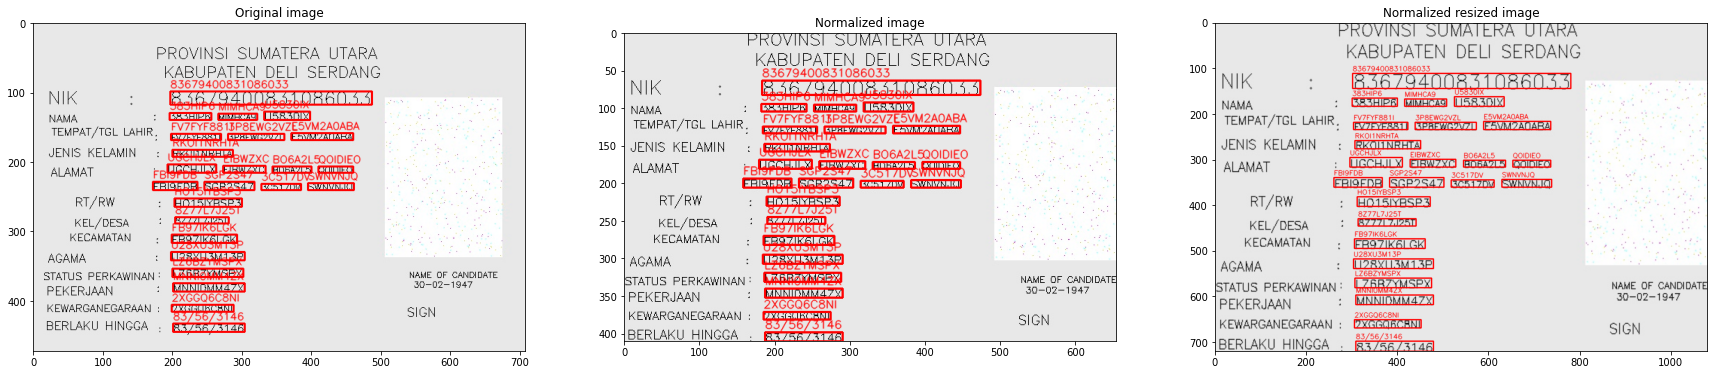

In [10]:
def plot_normalized_record(df, resize=(RESIZE_WIDTH, RESIZE_HEIGHT), sub_folder_images='images'):
    assert len(df['doc_xmin'].unique().tolist()) == 1 and len(df['doc_ymin'].unique().tolist()) == 1 and len(df['doc_xmax'].unique().tolist()) == 1 and len(df['doc_ymax'].unique().tolist()) == 1, 'df must have only one xmin, ymin, xmax and ymax values per document.'
    xmin, ymin, xmax, ymax = df['doc_xmin'].unique().tolist()[0], df['doc_ymin'].unique().tolist()[0], df['doc_xmax'].unique().tolist()[0], df['doc_ymax'].unique().tolist()[0]
    image = cv2.imread(os.path.join(df.iloc[0]['dir'], sub_folder_images,  df.iloc[0]['image']))
    image_copy = copy.deepcopy(image[ymin: ymax, xmin: xmax, :])
    image_resize = cv2.resize(image_copy, resize)
    for ind, row in df.iterrows():
        if row['label_names'] != "OTHERS":
            image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 2)
            image = cv2.putText(image, row['text'], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            image_copy = cv2.rectangle(image_copy, (int(row['n_x1']), int(row['n_y1'])), (int(row['n_x3']), int(row['n_y3'])), (255, 0, 0), 2)
            image_copy = cv2.putText(image_copy, row['text'], (int(row['n_x1']), int(row['n_y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            image_resize = cv2.rectangle(image_resize, (int(row['r_x1']), int(row['r_y1'])), (int(row['r_x3']), int(row['r_y3'])), (255, 0, 0), 2)
            image_resize = cv2.putText(image_resize, row['text'], (int(row['r_x1']), int(row['r_y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,15))
    ax1.imshow(image)
    ax1.set_title("Original image")
    ax2.imshow(image_copy)
    ax2.set_title("Normalized image")
    ax3.imshow(image_resize)
    ax3.set_title("Normalized resized image")

plot_normalized_record(processed_train_df[processed_train_df['image']=='1649053653308351_1000.jpg'])

OTHERS               31000
ALAMAT                3581
TEMPAT/TGL LAHIR      2012
NAMA                  1991
BERLAKU HINGGA        1000
AGAMA                 1000
JENIS KELAMIN         1000
NIK                   1000
PEKERJAAN             1000
STATUS PERKAWINAN     1000
KEL/DESA              1000
KEWARGANEGARAAN       1000
RT/RW                 1000
KECAMATAN             1000
Name: label_names, dtype: int64


<AxesSubplot:title={'center':'Label count across docs -> n = 1000'}>

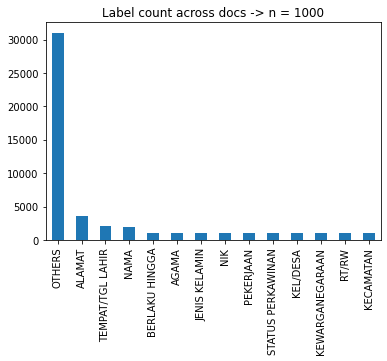

In [11]:
df_train_dataset = copy.deepcopy(processed_train_df[(~processed_train_df['label_names'].isnull())])
print(df_train_dataset['label_names'].value_counts())
df_train_dataset['label_names'].value_counts().plot(kind='bar', title=f"Label count across docs -> n = {df_train_dataset['image'].nunique()}")

OTHERS               7750
ALAMAT                930
NAMA                  503
TEMPAT/TGL LAHIR      488
BERLAKU HINGGA        250
JENIS KELAMIN         250
STATUS PERKAWINAN     250
AGAMA                 250
KEL/DESA              250
KEWARGANEGARAAN       250
NIK                   250
PEKERJAAN             250
RT/RW                 250
KECAMATAN             250
Name: label_names, dtype: int64


<AxesSubplot:title={'center':'Label count across docs -> n = 250'}>

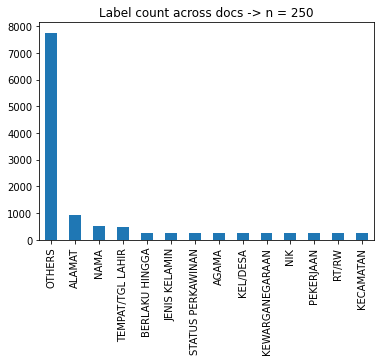

In [12]:
df_test_dataset = copy.deepcopy(processed_test_df[(~processed_test_df['label_names'].isnull())])
print(df_test_dataset['label_names'].value_counts())
df_test_dataset['label_names'].value_counts().plot(kind='bar', title=f"Label count across docs -> n = {df_test_dataset['image'].nunique()}")

In [13]:
# Refer - https://github.com/dhavalpotdar/Graph-Convolution-on-Structured-Documents/blob/7400704346cb9698f6c6b1ad3307d2439d17fa33/grapher.py#L11
class Graph:
    
    def __init__(self, df, max_nodes=100, columns=['r_x1', 'r_y1', 'r_x3', 'r_y3', 'text'], label='label'):
        self.df = df
        self.df.reset_index(inplace=True)
        self.max_nodes = max_nodes
        self.xmin, self.ymin, self.xmax, self.ymax, self.text = columns
        self.label = label
        self.special_chars = {i: ind for ind, i in enumerate(string.punctuation)}
    
    def get_features(self):
        
        def is_aplha(s):
            return int(s.isalpha())

        def is_numeric(s):
            return int(s.isnumeric())

        def is_alnum(s):
            return int(s.isalnum())

        def is_decimal_number(s):
            return int(bool(re.match("[\d.\d]+$", s)))

        def is_number_with_symbols(s):
            return int(bool(re.match("[\d{}]+$".format(re.escape(string.punctuation)), s)))

        def is_date(s, fuzzy=False):
            try: 
                parse(s, fuzzy=fuzzy)
                return 1
            except (ValueError, OverflowError):
                return 0
        
        feats = []
        for ind, row in self.df.iterrows():
            is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space = 0, 0, 0, 0, 0
            is_char_special = [0] * len(self.special_chars)
            is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date = 0, 0, 0, 0, 0, 0
            for c in row['text']:
                if c.islower(): is_char_lower += 1
                if c.isupper(): is_char_upper += 1
                if c.isalpha(): is_char_alpha += 1
                if c.isnumeric(): is_char_digit += 1
                if c.isspace(): is_char_space += 1
                if c in self.special_chars.keys():
                    is_char_special[self.special_chars[c]] += 1
            for word in row['text'].split():
                is_word_alpha += is_aplha(word)
                is_word_numeric += is_numeric(word)
                is_word_alnum += is_alnum(word)
                is_word_decimal_number += is_decimal_number(word)
                is_word_number_with_symbol += is_number_with_symbols(word)
                is_word_date += is_date(word)
            feat = [is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space] + \
                   is_char_special + \
                   [is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date] + \
                   [row['n_r_x1'], row['n_r_y1'], row['n_r_x2'], row['n_r_y2'], row['n_r_x3'], row['n_r_x3'], row['n_r_x4'], row['n_r_y4']]
            feats.append(feat)
        return np.asarray(feats)
    
    def pad_adj(self, adj_matrix):
        n = adj_matrix.shape[0]
        target = np.zeros((self.max_nodes, self.max_nodes))
        if n < self.max_nodes:
            target[:n, :n] = adj_matrix
        elif n > self.max_nodes:
            target = adj_matrix[:self.max_nodes, :self.max_nodes]
        else:
            target = adj_matrix
        return target
    
    def pad_feats(self, feats):
        target = np.zeros((self.max_nodes, feats.shape[1]))
        if feats.shape[0] < self.max_nodes:
            target[:feats.shape[0], :feats.shape[1]] = feats
        elif feats.shape[0] > self.max_nodes:
            target = feats[:self.max_nodes, :feats.shape[1]]
        else:
            target = feats
        return feats
    
    def get_edge_index(self):
        edge_index = []
        node_index = self.df.index.to_list()
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_ids'] in node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['vertically_close_object_ids'])])
                edge_index.append([node_index.index(row['vertically_close_object_ids']), node_index.index(ind)])
            if row['horizontally_close_object_ids'] in  node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['horizontally_close_object_ids'])])
                edge_index.append([node_index.index(row['horizontally_close_object_ids']), node_index.index(ind)])
        return np.asarray(edge_index).T
    
    def get_goemetric_data(self, index, features):
        return G_Data(x=torch.from_numpy(features).float().contiguous(), edge_index=torch.from_numpy(index).type(torch.LongTensor).contiguous(), y=torch.Tensor(self.df[self.label].to_list()).type(torch.LongTensor).contiguous())
        
    def make_graph(self):
        graph = nx.from_dict_of_lists(self.graph_dict)
        adj_matrix_sparse = nx.adjacency_matrix(graph)
        adj_matrix = np.asarray(adj_matrix_sparse.todense())
        padded_adj_matrix = self.pad_adj(adj_matrix)
        feats = self.get_features()
        padded_feats = self.pad_feats(feats)
        edge_index = self.get_edge_index()
        data = self.get_goemetric_data(edge_index, feats)
        return graph, padded_adj_matrix, padded_feats, adj_matrix, edge_index, feats, data
         
    def generate(self):
        distances_vertical, distances_horizontal = [], []
        nearest_dst_ids_vertical, nearest_dst_ids_horizontal = [], []
        x_src_coord_vertical, y_src_coord_vertical, x_dst_coord_vertical, y_dst_coord_vertical = [], [], [], []
        x_src_coord_horizontal, y_src_coord_horizontal, x_dst_coord_horizontal, y_dst_coord_horizontal = [], [], [], []
        for src_ind, src_row in self.df.iterrows():
            dst_attributes_vertical, dst_attributes_horizontal = [], []
            src_x_range = (src_row[self.xmin], src_row[self.xmax])
            src_y_range = (src_row[self.ymin], src_row[self.ymax])
            src_centroid_x = (src_x_range[0] + src_x_range[1]) / 2
            src_centroid_y = (src_y_range[0] + src_y_range[1]) / 2
            for dst_ind, dst_row in self.df.iterrows():
                dst_x_range = (dst_row[self.xmin], dst_row[self.xmax])
                dst_y_range = (dst_row[self.ymin], dst_row[self.ymax])
                dst_centroid_x = (dst_x_range[0] + dst_x_range[1]) / 2
                dst_centroid_y = (dst_y_range[0] + dst_y_range[1]) / 2
                if src_ind != dst_ind:
                    if dst_centroid_y > src_centroid_y:
                        if dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (src_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (dst_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (src_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[0] <= src_x_range[1] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (dst_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                if dst_centroid_x > src_centroid_x:
                    if dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + src_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (dst_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[0] <= src_y_range[1] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
            dst_attributes_vertical_sorted, dst_attributes_horizontal_sorted = sorted(dst_attributes_vertical, key=lambda x: x[3]), sorted(dst_attributes_horizontal, key=lambda x: x[3])
            if len(dst_attributes_vertical_sorted) == 0:
                nearest_dst_ids_vertical.append(-1)
                x_src_coord_vertical.append(-1)
                y_src_coord_vertical.append(-1)
                x_dst_coord_vertical.append(-1)
                y_dst_coord_vertical.append(-1)
                distances_vertical.append(-1)
            else:
                nearest_dst_ids_vertical.append(dst_attributes_vertical_sorted[0][0])
                x_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][0])
                y_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][1])
                x_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][0])
                y_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][1])
                distances_vertical.append(dst_attributes_vertical_sorted[0][3])
            if len(dst_attributes_horizontal_sorted) == 0:
                nearest_dst_ids_horizontal.append(-1)
                x_src_coord_horizontal.append(-1)
                y_src_coord_horizontal.append(-1)
                x_dst_coord_horizontal.append(-1)
                y_dst_coord_horizontal.append(-1)
                distances_horizontal.append(-1)
            else:
                nearest_dst_ids_horizontal.append(dst_attributes_horizontal_sorted[0][0])
                x_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][0])
                y_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][1])
                x_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][0])
                y_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][1])
                distances_horizontal.append(dst_attributes_horizontal_sorted[0][3])
        vertically_close_objects, horizontally_close_objects = [], []
        for i in nearest_dst_ids_vertical:
            if i == -1:
                vertically_close_objects.append('')
            else:
                vertically_close_objects.append(self.df.loc[i, 'text'])
        for i in nearest_dst_ids_horizontal:
            if i == -1:
                horizontally_close_objects.append('')
            else:
                horizontally_close_objects.append(self.df.loc[i, 'text'])
        self.df['vertically_close_objects'] = vertically_close_objects
        self.df['vertically_close_object_ids'] = nearest_dst_ids_vertical
        self.df['vertically_close_object_x_src_coord_centroid'] = x_src_coord_vertical
        self.df['vertically_close_object_y_src_coord_centroid'] = y_src_coord_vertical
        self.df['vertically_close_object_x_dst_coord_centroid'] = x_dst_coord_vertical
        self.df['vertically_close_object_y_dst_coord_centroid'] = y_dst_coord_vertical
        self.df['vertically_close_object_distances'] = distances_vertical
        self.df['horizontally_close_objects'] = horizontally_close_objects
        self.df['horizontally_close_object_ids'] = nearest_dst_ids_horizontal
        self.df['horizontally_close_object_x_src_coord_centroid'] = x_src_coord_horizontal
        self.df['horizontally_close_object_y_src_coord_centroid'] = y_src_coord_horizontal
        self.df['horizontally_close_object_x_dst_coord_centroid'] = x_dst_coord_horizontal
        self.df['horizontally_close_object_y_dst_coord_centroid'] = y_dst_coord_horizontal
        self.df['horizontally_close_object_distances'] = distances_horizontal
        grouped_vertical = self.df.groupby('vertically_close_object_ids')['vertically_close_object_distances'].min()
        grouped_horizontal = self.df.groupby('horizontally_close_object_ids')['horizontally_close_object_distances'].min()
        grouped_vertical_dict = dict(zip(grouped_vertical.index, grouped_vertical.values))
        grouped_horizontal_dict = dict(zip(grouped_horizontal.index, grouped_horizontal.values))
        for ind, row in self.df.iterrows():
            vertically_close_object_id = row['vertically_close_object_ids']
            horizontally_close_object_id = row['horizontally_close_object_ids']
            if row['vertically_close_object_distances'] > grouped_vertical_dict[vertically_close_object_id]:
                row['vertically_close_object_x_src_coord_centroid'] = row['vertically_close_object_y_src_coord_centroid'] = \
                row['vertically_close_object_x_dst_coord_centroid'] = row['vertically_close_object_y_dst_coord_centroid'] = -1
                row['vertically_close_object_distances'] = -1
            if row['horizontally_close_object_distances'] > grouped_horizontal_dict[horizontally_close_object_id]:
                row['horizontally_close_object_x_src_coord_centroid'] = row['horizontally_close_object_y_src_coord_centroid'] = \
                row['horizontally_close_object_x_dst_coord_centroid'] = row['horizontally_close_object_y_dst_coord_centroid'] = -1
                row['horizontally_close_object_distances'] = -1
        self.graph_dict = {i: [] for i in self.df.index.to_list()}
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['vertically_close_object_ids'])
            if row['horizontally_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['horizontally_close_object_ids'])
        return self.df.drop(columns=['index'], inplace=True), self.graph_dict
    
    def graph(self):
        self.generate()
        graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data = self.make_graph()
        return self.df, self.graph_dict, graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data

In [14]:
__df__, __graph_dict__, __graph__, __padded_adj_matrix__, __padded_features__, __adj_matrix__, __edge_index__, __features__, __data__ = Graph(processed_train_df[processed_train_df['image']=='1649053653308351_1000.jpg']).graph()

In [15]:
__df__

dir                      image  \
0   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
1   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
2   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
3   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
4   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
5   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
6   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
7   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
8   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
9   ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
10  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
11  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
12  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
13  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
14  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
15  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
16  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
17  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
18  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
19  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
20  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
21  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
22  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
23  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
24  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
25  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
26  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
27  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
28  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
29  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
30  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
31  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
32  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
33  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
34  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
35  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
36  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
37  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
38  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
39  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
40  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
41  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
42  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
43  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
44  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
45  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
46  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
47  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
48  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
49  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
50  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
51  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
52  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
53  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   
54  ../data/processed/ktp_synthetic/train  1649053653308351_1000.jpg   

     

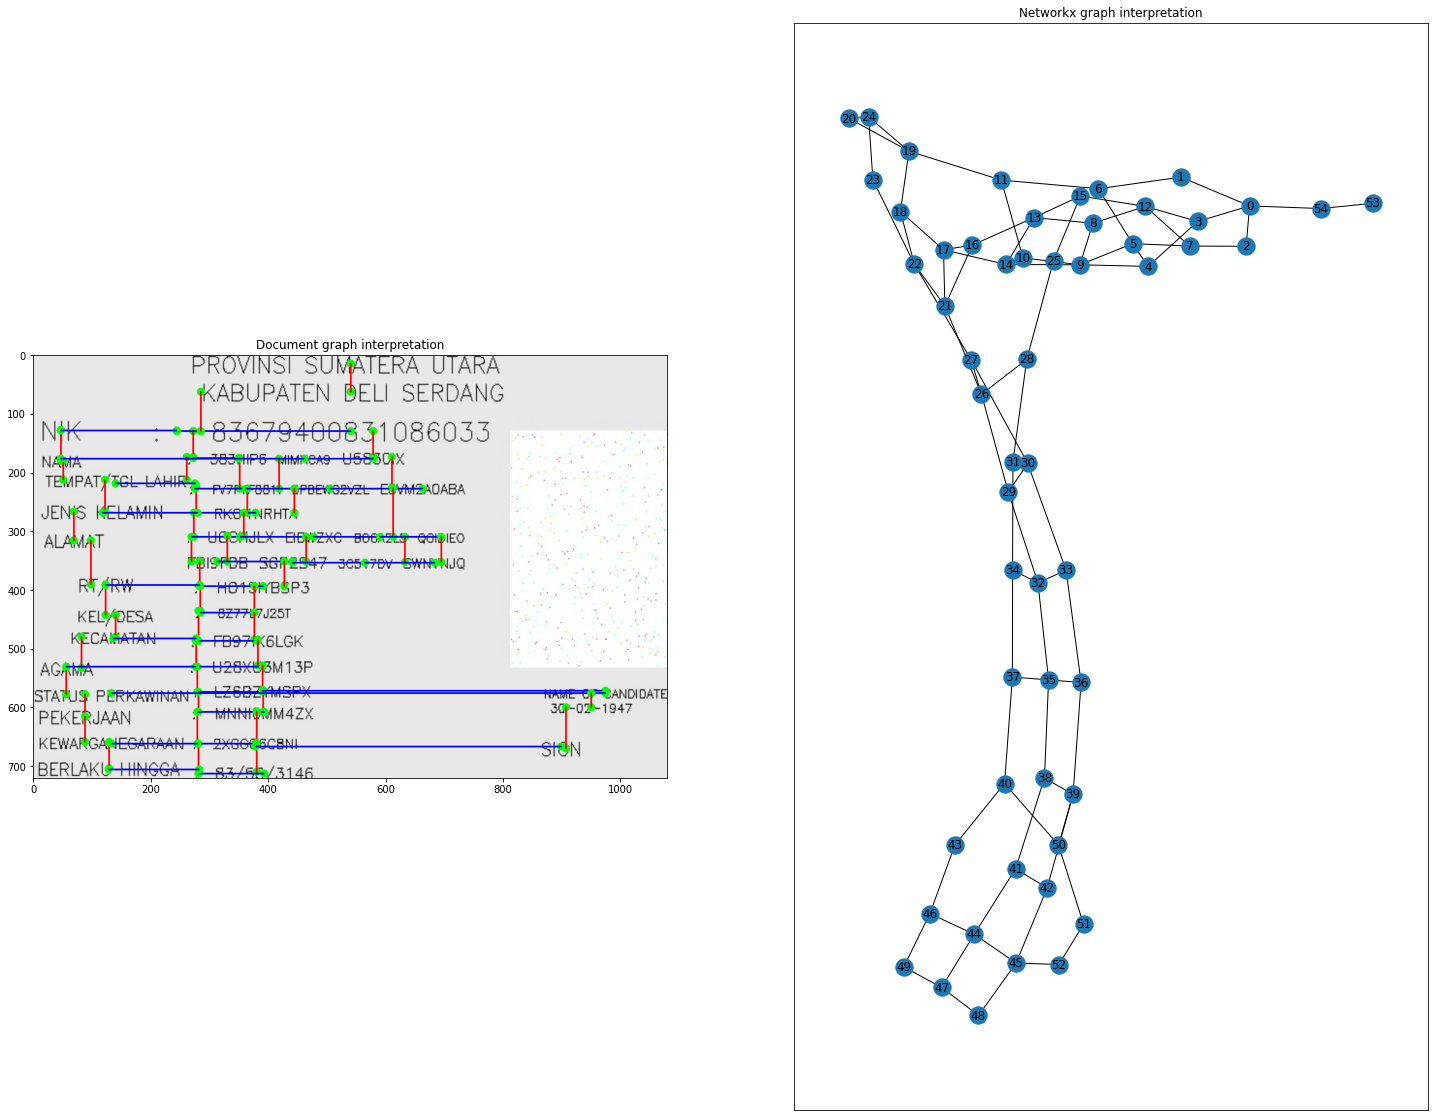

In [16]:
def plot_document_graph(df, g, resize=(RESIZE_WIDTH, RESIZE_HEIGHT), sub_folder_images='images'):
    assert df['image'].nunique() == 1, 'The plot is only for one document. Pass a df corresponding to only image/txt file.'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
    dir_path, image_file = df['dir'].unique()[0], df['image'].unique()[0]
    doc_xmin, doc_ymin, doc_xmax, doc_ymax = df['doc_xmin'].unique()[0], df['doc_ymin'].unique()[0], df['doc_xmax'].unique()[0], df['doc_ymax'].unique()[0]
    image = cv2.imread(os.path.join(dir_path, sub_folder_images, image_file))
    image = image[doc_ymin: doc_ymax, doc_xmin: doc_xmax, :]
    image = cv2.resize(image, resize)
    for ind, row in df.iterrows():
        if row['vertically_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), color=(255, 0, 0), thickness=2)
        if row['horizontally_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), color=(0, 0, 255), thickness=2)
    ax1.imshow(image)
    ax1.set_title('Document graph interpretation')
    ax2.set_title('Networkx graph interpretation')
    nx.draw_networkx(g, ax=ax2)

plot_document_graph(__df__, __graph__)

In [17]:
print(df_train_dataset['label'].value_counts())
ce_train_weights = np.asarray([1 - (i / len(df_train_dataset)) for i in list(df_train_dataset['label'].value_counts().sort_index())])
ce_train_weights

0     31000
5      3581
3      2012
2      1991
13     1000
12     1000
11     1000
10     1000
9      1000
8      1000
7      1000
6      1000
4      1000
1      1000
Name: label, dtype: int64


array([0.36192985, 0.97941709, 0.95901943, 0.95858719, 0.97941709,
       0.92629261, 0.97941709, 0.97941709, 0.97941709, 0.97941709,
       0.97941709, 0.97941709, 0.97941709, 0.97941709])

In [18]:
def plot_graph(g, ind):
    figure = plt.figure(figsize=(15, 15))
    plt.title(f'Graph for data point at index {ind}')
    nx.draw_networkx(g)
    
def create_graph_dataset(df):
    graphs, dataset = [], []
    docs = list(df['image'].unique())
    for doc in tqdm(docs):
        _, _, graph, _, _, _, _, _, data = Graph(df[df['image']==doc]).graph()
        if len(data.edge_index.shape) == 2:
            graphs.append(graph)
            dataset.append(data)
    return graphs, dataset

train_graphs, train_dataset = create_graph_dataset(df_train_dataset)
test_graphs, test_dataset = create_graph_dataset(df_test_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.67it/s]


Count of valid and cleaned data = 1000


Data(x=[53, 51], edge_index=[2, 164], y=[53])

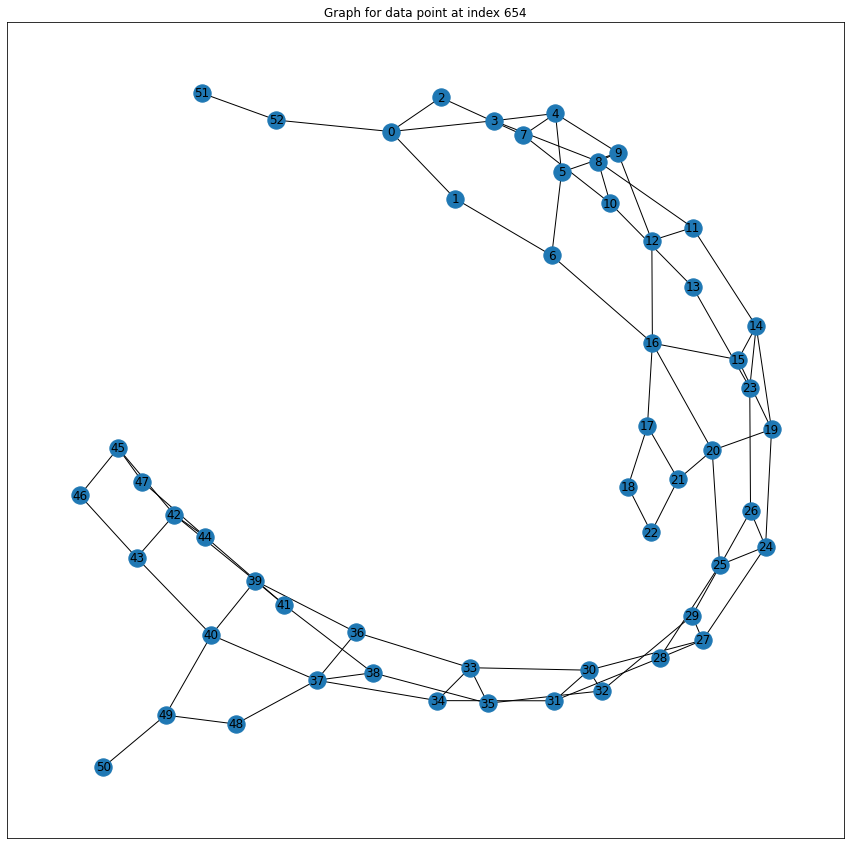

In [19]:
ind = random.choice(np.arange(0, len(train_graphs)))
plot_graph(train_graphs[ind], ind)
print('Count of valid and cleaned data =', len(train_dataset))
train_dataset[ind]

In [20]:
def get_data_module(dataset, val_split=0.1, test_split=0.1, batch_size=8, random_seed=42):
    random.seed(random_seed)
    random.shuffle(dataset)
    dataset_length = len(dataset)
    train_dataset = dataset[: int(dataset_length * (1 - (val_split + test_split)))]
    val_dataset = dataset[int(dataset_length * (1 - (val_split + test_split))): int(dataset_length * (1 - val_split))]
    test_dataset = dataset[int(dataset_length * (1 - val_split)): ]
    return train_dataset, val_dataset, test_dataset, G_LightningDataset(train_dataset, val_dataset, test_dataset, batch_size) if val_dataset and test_dataset else G_LightningDataset(train_dataset, batch_size)

train_dataset, val_dataset, test_dataset, data_module = get_data_module(train_dataset)

In [21]:
def visualize_tsne(h, color, n_components=2):
    if isinstance(h, np.ndarray):
        z = TSNE(n_components=n_components).fit_transform(h)
    else:
        z = TSNE(n_components=n_components).fit_transform(h.detach().cpu().numpy())       
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('TSNE for GCN output')
    plt.scatter(z[:, 0], z[:, 1], s=75, c=color, cmap='Set1')
    plt.show()

In [22]:
class GCN(torch.nn.Module):
    
    def __init__(self, num_features, num_classes, is_spectral=False, K=3, dropout=0.2, torch_seed=42):
        super().__init__()
        torch.manual_seed(torch_seed)
        self.dropout=dropout
        if is_spectral:
            self.conv1 = ChebConv(num_features, 32, K=K)
            self.conv2 = ChebConv(32, 16, K=K)
            self.conv3 = ChebConv(16, num_classes, K=K)
        else:
            self.conv1 = GCNConv(num_features, 32, improved=True)
            self.conv2 = GCNConv(32, 16, improved=True)
            self.conv3 = GCNConv(16, num_classes, improved=True)

    def forward(self, x, edge_index):
        x = F.dropout(self.conv1(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.dropout(self.conv2(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.log_softmax(self.conv3(x, edge_index), dim=1)
        return x

GCN(
  (conv1): GCNConv(51, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 14)
)
Model output shape =  torch.Size([55, 14])


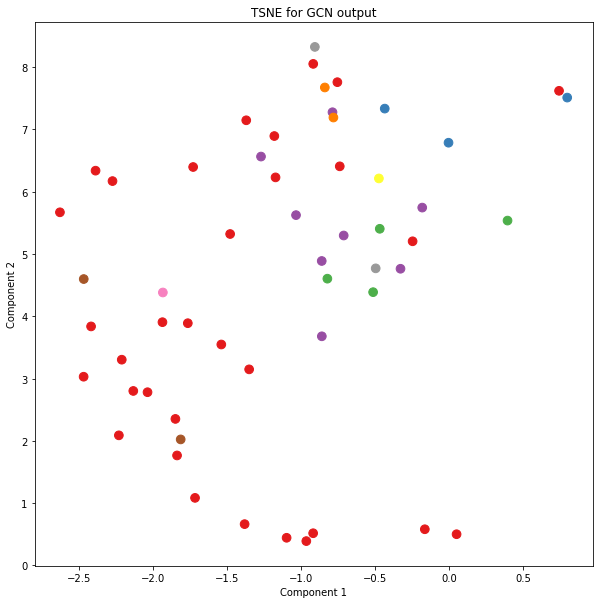

In [23]:
__model__ = GCN(num_features=51, num_classes=len(LABELS))
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

GCN(
  (conv1): ChebConv(51, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 16, K=3, normalization=sym)
  (conv3): ChebConv(16, 14, K=3, normalization=sym)
)
Model output shape =  torch.Size([55, 14])


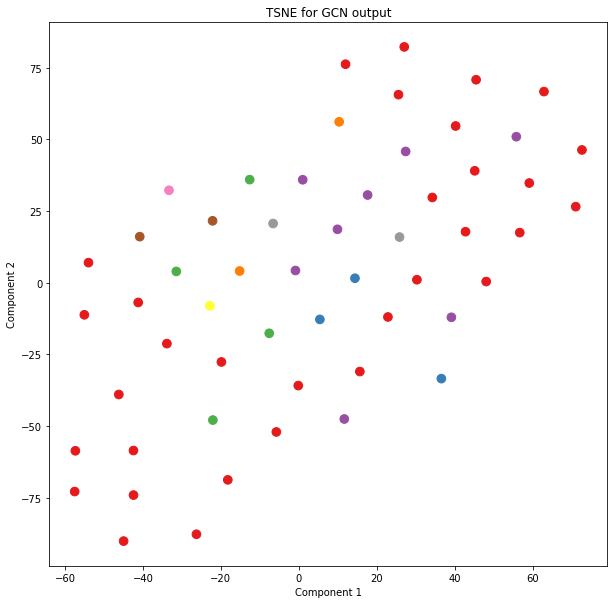

In [24]:
__model__ = GCN(num_features=51, num_classes=len(LABELS), is_spectral=True)
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

In [25]:
class LitGCN(pl.LightningModule):

    def __init__(self, ce_weights, is_spectral=False, num_features=51, num_classes=len(LABELS), batch_size=128, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.ce_weights = ce_weights
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = GCN(num_features=num_features, num_classes=num_classes, is_spectral=is_spectral)
        self.learning_rate=learning_rate
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x, edge_index):
        return self.model(x, edge_index)

    def training_step(self, train_batch, batch_idx):
        data = train_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitGCN(ce_weights=self.ce_weights), [torch.randn((69, 51)), torch.randint(0, 69, (2, 100)).type(torch.LongTensor)])
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        data = val_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        data = test_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

In [26]:
def test_model(ckpt, ce_weights, demo_data, is_spectral=False):
    model = LitGCN.load_from_checkpoint(checkpoint_path=ckpt, ce_weights=ce_weights, is_spectral=is_spectral)
    model.eval()
    out = model(demo_data.x, demo_data.edge_index)
    print('Model output shape = ', out.size())
    visualize_tsne(out, color=demo_data.y)
    df_model_res = {
        'pred_label': [],
        'true_label': []
    }
    for test_data in test_dataset:
        y_hat = model(test_data.x, test_data.edge_index)
        y_hat = y_hat.cpu().detach().numpy()
        y_hat = np.argmax(y_hat, axis=1)
        y = test_data.y.cpu().detach().numpy()
        for i in range(len(y)):
            df_model_res['pred_label'].append(y_hat[i])
            df_model_res['true_label'].append(y[i])
    df_model_res = pd.DataFrame.from_dict(df_model_res)
    print(classification_report(df_model_res['pred_label'], df_model_res['true_label']))
    return df_model_res

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at ../logs/temp/lr_find_temp_model_dd3e58d6-985d-4a14-a725-623a10e0be7f.ckpt


CPU times: user 2.96 s, sys: 524 ms, total: 3.48 s
Wall time: 4.28 s


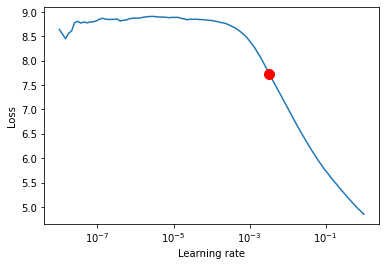

In [27]:
%%time
model_spectral = LitGCN(ce_weights=ce_train_weights, is_spectral=True)
trainer_spectral = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir='../logs/'+'/temp')
lr_finder_spectral = trainer_spectral.tuner.lr_find(model_spectral, data_module)
fig = lr_finder_spectral.plot(suggest=True)
fig.show()

In [28]:
%%time
# mlflow.pytorch.autolog()
trainer_spectral = pl.Trainer(default_root_dir=f'../runs/saved_models/pytorch-lightning/synt/{DOC_TYPE}',
                             precision=32,
                             limit_train_batches=0.5,
                             gpus=1 if torch.cuda.is_available() else None, 
                             max_epochs=50,
                             logger=TensorBoardLogger(f'../runs/saved_models/pytorch-lightning/synt/{DOC_TYPE}', name='spectral_gcn'),
                             callbacks=[
                                    LearningRateMonitor(logging_interval="step"), 
                                    ModelCheckpoint(monitor="train_loss"),
                                ],
                             # resume_from_checkpoint=conf.MODEL_SAVED_PATH + '/' +'spectral_gcn' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                             )
# with mlflow.start_run(run_name=SPECTRAL_EXPERIMENT_NAME + ' ' + datetime.now().strftime('%d-%m-%Y %H:%M'), tags={'time': datetime.now().strftime('%d-%m-%Y %H:%M')}) as run:
trainer_spectral.fit(LitGCN(ce_weights=ce_train_weights, is_spectral=True), data_module)
trainer_spectral.test(ckpt_path="best", datamodule=data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ../runs/saved_models/pytorch-lightning/synt/ktp/spectral_gcn

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | Accuracy         | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | model     | GCN              | 7.2 K 
-----------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

2022-04-18 12:22:43.983132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-18 12:22:43.983158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: Lightnin

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9839252233505249, 'test_loss': 0.1044408455491066}
--------------------------------------------------------------------------------
CPU times: user 45.4 s, sys: 1.21 s, total: 46.6 s
Wall time: 45.3 s


[{'test_loss': 0.1044408455491066, 'test_acc': 0.9839252233505249}]

Best path -  ../runs/saved_models/pytorch-lightning/synt/ktp/spectral_gcn/version_0/checkpoints/epoch=49-step=2499.ckpt
Model output shape =  torch.Size([55, 14])


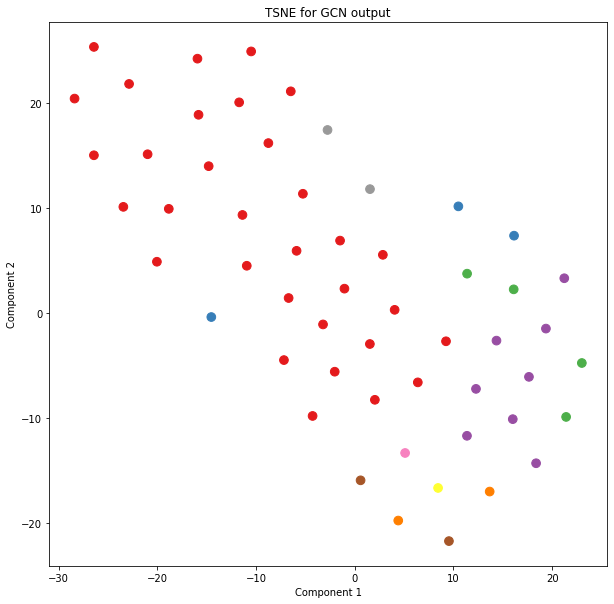

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3103
           1       1.00      1.00      1.00       100
           2       0.88      0.95      0.91       184
           3       0.89      0.86      0.88       207
           4       0.94      0.97      0.95        97
           5       0.99      0.96      0.97       353
           6       0.93      0.92      0.93       101
           7       0.95      0.96      0.95        99
           8       0.95      0.98      0.96        97
           9       0.98      0.94      0.96       104
          10       0.95      1.00      0.97        95
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100

    accuracy                           0.98      4840
   macro avg       0.96      0.97      0.96      4840
weighted avg       0.98      0.98      0.98      4840



In [29]:
print('Best path - ', trainer_spectral.checkpoint_callbacks[0].best_model_path)
res_spectral = test_model(trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_train_weights, __data__, is_spectral=True)

In [30]:
print(classification_report(res_spectral[res_spectral['true_label'] != 0]['pred_label'], res_spectral[res_spectral['true_label'] != 0]['true_label']))
res_spectral[res_spectral['true_label'] != 0]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      1.00      1.00       100
           2       0.88      0.96      0.92       182
           3       0.89      0.86      0.88       207
           4       0.94      0.97      0.95        97
           5       0.99      0.96      0.97       353
           6       0.93      0.92      0.93       101
           7       0.95      0.96      0.95        99
           8       0.95      0.98      0.96        97
           9       0.98      0.94      0.96       104
          10       0.95      1.00      0.97        95
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100

    accuracy                           0.95      1740
   macro avg       0.89      0.90      0.89      1740
weighted avg       0.95      0.95      0.95      1740



pred_label  true_label
1              1           1
4              2           2
7              3           3
8              3           3
11             4           4
...          ...         ...
4821           9           9
4824          10          10
4827          11          11
4830          12          12
4833          13          13

[1740 rows x 2 columns]

In [31]:
res_spectral[(res_spectral['true_label'] != res_spectral['pred_label']) & (res_spectral['true_label'] != 0)]

pred_label  true_label
53             4           3
145            3           2
239            3           2
289            6           3
390            0           5
...          ...         ...
4506           2           3
4509           3           4
4525           6           7
4604           2           3
4615           0           6

[79 rows x 2 columns]

<AxesSubplot:ylabel='Density'>

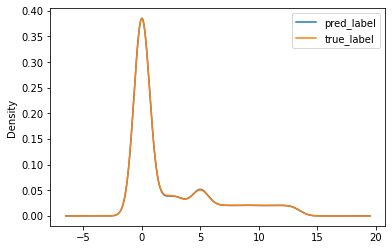

In [32]:
res_spectral.plot.kde()

In [33]:
processed_test_df

dir                     image  \
0      ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
1      ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
2      ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
3      ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
4      ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
...                                     ...                       ...   
12166  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
12167  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
12168  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
12169  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
12170  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   

                            txt                       json  width  height  \
0        1649053621542494_1.txt    1649053621542494_1.json    664     442   
1        1649053621542494_1.txt    1649053621542494_1.json    664     442   
2        1649053621542494_1.txt    1649053621542494_1.json    664     442   
3        1649053621542494_1.txt    1649053621542494_1.json    664     442   
4        1649053621542494_1.txt    1649053621542494_1.json    664     442   
...                         ...                        ...    ...     ...   
12166  1649053624588558_250.txt  1649053624588558_250.json    729     486   
12167  1649053624588558_250.txt  1649053624588558_250.json    729     486   
12168  1649053624588558_250.txt  1649053624588558_250.json    729     486   
12169  1649053624588558_250.txt  1649053624588558_250.json    729     486   
12170  1649053624588558_250.txt  1649053624588558_250.json    729     486   

       normalized_width  normalized_height  doc_xmin  doc_xmax  ...    n_r_y2  \
0                   623                383        12       635  ...  0.164491   
1                   623                383        12       635  ...  0.164491   
2                   623                383        12       635  ...  0.169713   
3                   623                383        12       635  ...  0.245431   
4                   623                383        12       635  ...  0.240209   
...                 ...                ...       ...       ...  ...       ...   
12166               686                411        14       700  ...  0.822384   
12167               686                411        14       700  ...  0.858881   
12168               686                411        14       700  ...  0.965937   
12169               686                411        14       700  ...  0.000000   
12170               686                411        14       700  ...  0.090024   

         n_r_x3    n_r_y3    n_r_x4    n_r_y4  resize_width  resize_height  \
0      0.263242  0.214099  0.182986  0.214099          1080            720   
1      0.744783  0.214099  0.279294  0.214099          1080            720   
2      0.080257  0.214099  0.017657  0.214099          1080            720   
3      0.264848  0.271540  0.243981  0.271540          1080            720   
4      0.393258  0.271540  0.280899  0.271540          1080            720   
...         ...       ...       ...       ...           ...            ...   
12166  1.000000  0.846715  0.788630  0.846715          1080            720   
12167  0.932945  0.880779  0.807580  0.880779          1080            720   
12168  0.848397  1.000000  0.784257  1.000000          1080            720   
12169  0.720117  0.041363  0.253644  0.041363          1080            720   
12170  0.717201  0.131387  0.259475  0.131387          1080            720   

                          text  label_names  label  
0                            :       OTHERS      0  
1            46131497239774736          NIK      1  
2                          NIK       OTHERS      0  
3                            :       OTHERS      0  
4                      7H4JPYX         NAMA      2  
...       

In [34]:
def plot_record_inf(df, sub_folder_images="images"):
    assert len(df['dir'].unique().tolist()) == 1, 'df must have only one document.'
    image = cv2.imread(os.path.join(df.iloc[0]['dir'], sub_folder_images, df.iloc[0]['image']))
    for ind, row in df.iterrows():
        if row['label_pred'] != LABELS['others']:
            image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 2)
            image = cv2.putText(image, row['label_names_pred'], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            if isinstance(row['label_names'], str):
                image = cv2.putText(image, row['label_names'], (int(row['x2']), int(row['y2'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)            
    fig = plt.figure(figsize=(30,15))
    plt.imshow(image)

def inference(df, model, verbose=True, sub_folder_images="images"):
    model.eval()
    inf_df = copy.deepcopy(df)
    inf_df, graph_dict, graph, padded_adj_matrix, padded_features, adj_matrix, edge_index, features, data = Graph(inf_df).graph()
    y_hat = model(data.x, data.edge_index)
    y_hat = y_hat.cpu().detach().numpy()
    out = copy.deepcopy(y_hat)
    y_hat = np.argmax(y_hat, axis=1)
    inf_df['label_pred'] = list(y_hat)
    inf_df['label_names_pred'] = inf_df['label_pred'].apply(lambda x: IND_LABELS[str(x)].upper())
    if verbose:
        visualize_tsne(out, y_hat)
        plot_document_graph(inf_df, graph, sub_folder_images=sub_folder_images)
        plot_record_inf(inf_df, sub_folder_images)
    return inf_df

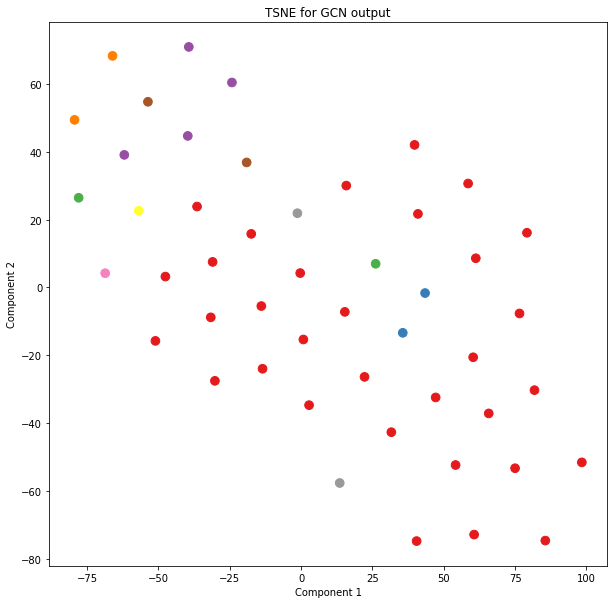

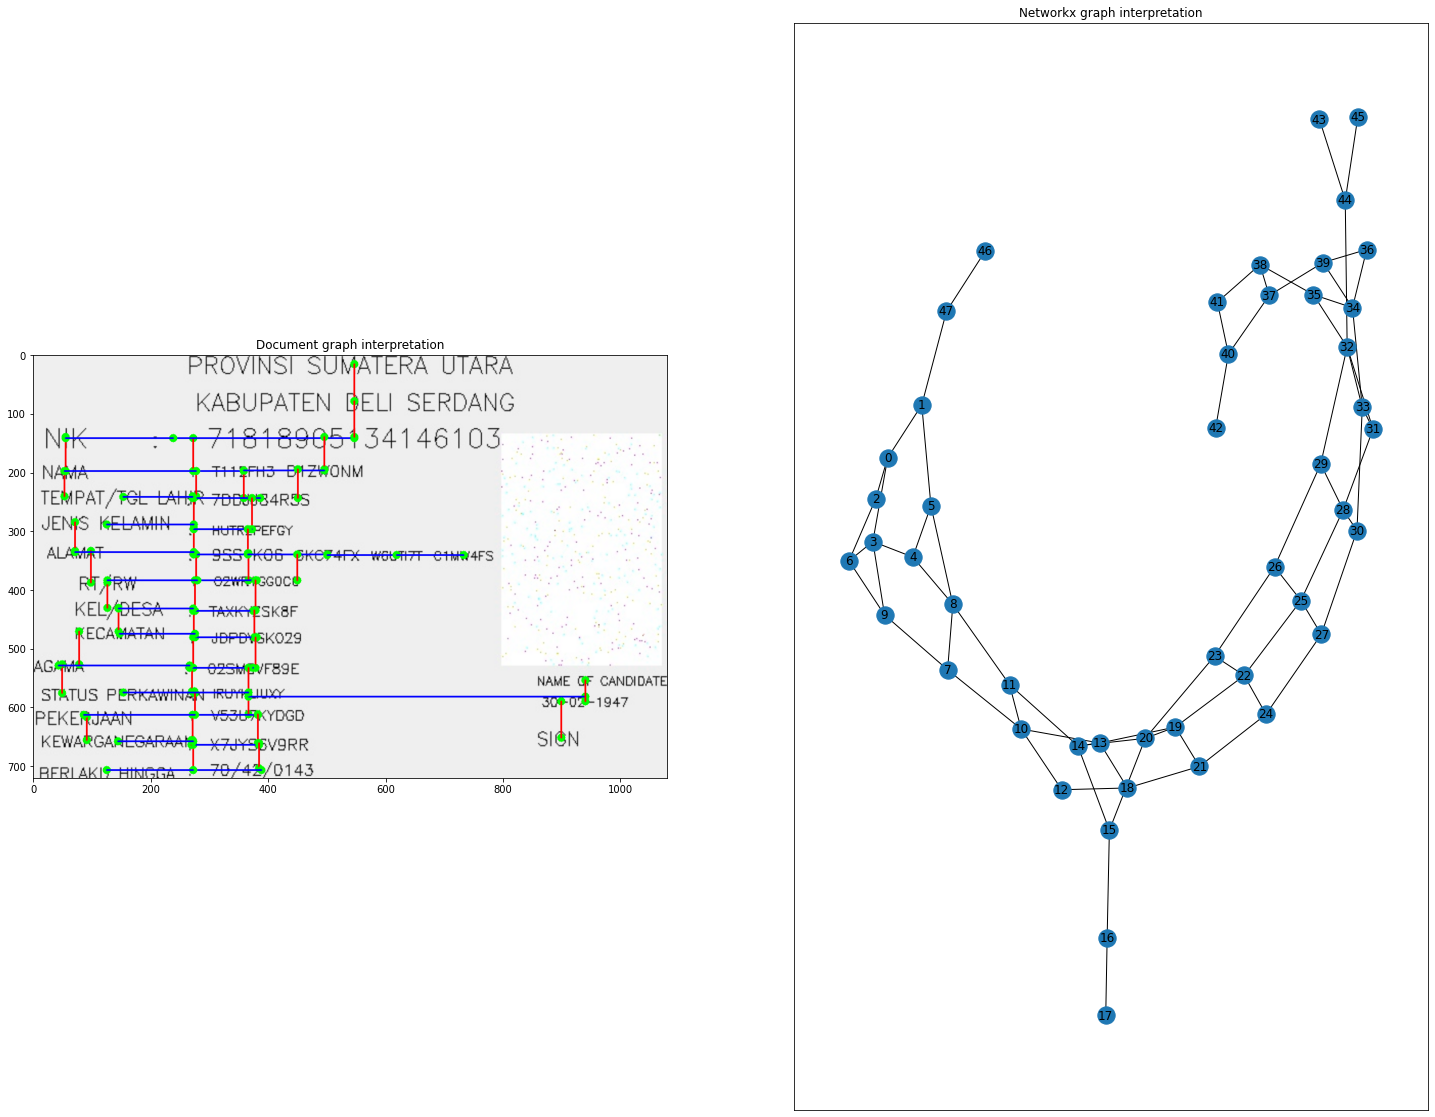

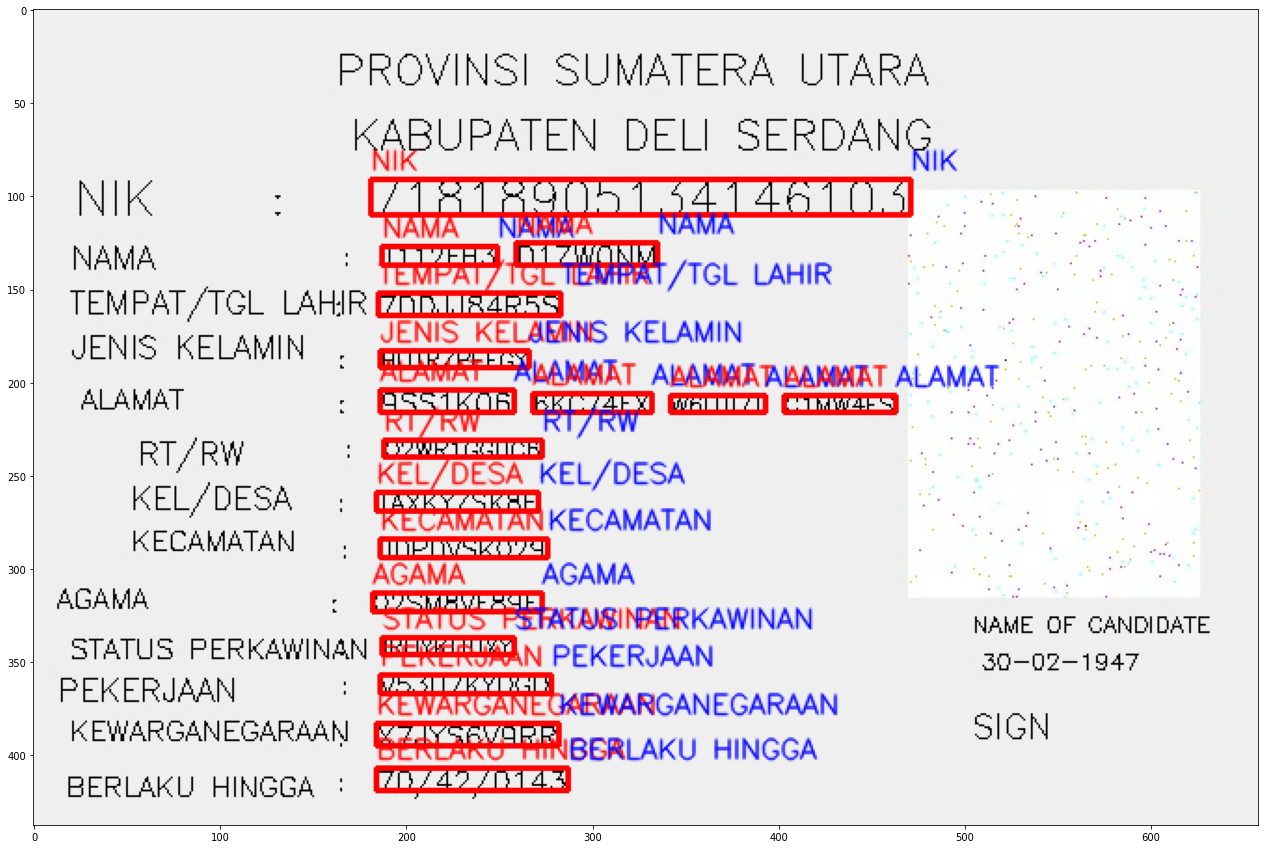

In [35]:
__test_df__ = processed_test_df[processed_test_df['image'] == random.choice(processed_test_df['image'].unique().tolist())]
__res__ = inference(__test_df__, LitGCN.load_from_checkpoint(checkpoint_path=trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_weights=ce_train_weights*0+1, is_spectral=True))

In [40]:
res_df = pd.DataFrame()
for image in processed_test_df['image'].unique().tolist():
    print(f'Processing - {image} ...')
    test_df = processed_test_df[processed_test_df['image'] == image]
    res = inference(test_df, LitGCN.load_from_checkpoint(checkpoint_path=trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_weights=ce_train_weights*0+1, is_spectral=True), verbose=False)
    res_df = pd.concat([res_df, res])    

Processing - 1649053621542494_1.jpg ...
Processing - 1649053621557471_2.jpg ...
Processing - 1649053621571167_3.jpg ...
Processing - 1649053621583172_4.jpg ...
Processing - 1649053621596977_5.jpg ...
Processing - 1649053621610843_6.jpg ...
Processing - 1649053621625163_7.jpg ...
Processing - 1649053621637522_8.jpg ...
Processing - 1649053621649354_9.jpg ...
Processing - 1649053621661130_10.jpg ...
Processing - 1649053621673025_11.jpg ...
Processing - 1649053621683774_12.jpg ...
Processing - 1649053621694549_13.jpg ...
Processing - 1649053621705771_14.jpg ...
Processing - 1649053621717441_15.jpg ...
Processing - 1649053621740847_17.jpg ...
Processing - 1649053621752970_18.jpg ...
Processing - 1649053621767564_19.jpg ...
Processing - 1649053621780968_20.jpg ...
Processing - 1649053621793254_21.jpg ...
Processing - 1649053621803833_22.jpg ...
Processing - 1649053621815238_23.jpg ...
Processing - 1649053621826137_24.jpg ...
Processing - 1649053621838650_25.jpg ...
Processing - 164905362185

Processing - 1649053623933215_196.jpg ...
Processing - 1649053623945221_197.jpg ...
Processing - 1649053623958203_198.jpg ...
Processing - 1649053623971704_199.jpg ...
Processing - 1649053623983273_200.jpg ...
Processing - 1649053624007005_202.jpg ...
Processing - 1649053624023185_203.jpg ...
Processing - 1649053624040114_204.jpg ...
Processing - 1649053624053262_205.jpg ...
Processing - 1649053624064935_206.jpg ...
Processing - 1649053624077496_207.jpg ...
Processing - 1649053624088146_208.jpg ...
Processing - 1649053624099423_209.jpg ...
Processing - 1649053624111168_210.jpg ...
Processing - 1649053624121527_211.jpg ...
Processing - 1649053624133691_212.jpg ...
Processing - 1649053624145222_213.jpg ...
Processing - 1649053624157037_214.jpg ...
Processing - 1649053624169063_215.jpg ...
Processing - 1649053624196122_217.jpg ...
Processing - 1649053624207678_218.jpg ...
Processing - 1649053624220329_219.jpg ...
Processing - 1649053624231247_220.jpg ...
Processing - 1649053624241724_221.

In [41]:
print(classification_report(res_df['label'], res_df['label_pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7750
           1       1.00      1.00      1.00       250
           2       0.95      0.90      0.92       503
           3       0.86      0.89      0.87       488
           4       0.96      0.95      0.96       250
           5       0.96      0.98      0.97       930
           6       0.98      0.94      0.96       250
           7       0.96      0.97      0.97       250
           8       0.94      0.93      0.93       250
           9       0.95      0.96      0.96       250
          10       0.98      0.97      0.98       250
          11       0.99      0.98      0.99       250
          12       0.99      1.00      0.99       250
          13       1.00      1.00      1.00       250

    accuracy                           0.98     12171
   macro avg       0.97      0.96      0.96     12171
weighted avg       0.98      0.98      0.98     12171



In [42]:
res_df

dir                     image  \
0   ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
1   ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
2   ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
3   ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
4   ../data/processed/ktp_synthetic/test    1649053621542494_1.jpg   
..                                   ...                       ...   
42  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
43  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
44  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
45  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   
46  ../data/processed/ktp_synthetic/test  1649053624588558_250.jpg   

                         txt                       json  width  height  \
0     1649053621542494_1.txt    1649053621542494_1.json    664     442   
1     1649053621542494_1.txt    1649053621542494_1.json    664     442   
2     1649053621542494_1.txt    1649053621542494_1.json    664     442   
3     1649053621542494_1.txt    1649053621542494_1.json    664     442   
4     1649053621542494_1.txt    1649053621542494_1.json    664     442   
..                       ...                        ...    ...     ...   
42  1649053624588558_250.txt  1649053624588558_250.json    729     486   
43  1649053624588558_250.txt  1649053624588558_250.json    729     486   
44  1649053624588558_250.txt  1649053624588558_250.json    729     486   
45  1649053624588558_250.txt  1649053624588558_250.json    729     486   
46  1649053624588558_250.txt  1649053624588558_250.json    729     486   

    normalized_width  normalized_height  doc_xmin  doc_xmax  ...  \
0                623                383        12       635  ...   
1                623                383        12       635  ...   
2                623                383        12       635  ...   
3                623                383        12       635  ...   
4                623                383        12       635  ...   
..               ...                ...       ...       ...  ...   
42               686                411        14       700  ...   
43               686                411        14       700  ...   
44               686                411        14       700  ...   
45               686                411        14       700  ...   
46               686                411        14       700  ...   

    vertically_close_object_distances  horizontally_close_objects  \
0                           49.817232           46131497239774736   
1                           47.937337                               
2                           53.577023                           :   
3                           42.297650                     7H4JPYX   
4                           41.357702                               
..                                ...                         ...   
42                          25.401460                               
43                          81.459854                               
44                          -1.000000                               
45                          64.817518                               
46                          59.562044                               

    horizontally_close_object_ids  \
0                               1   
1                              -1   
2                               0   
3                               4   
4                              -1   
..                            ...   
42                             -1   
43                             -1   
44                             -1   
45                             -1   
46                             -1   

    horizontally_close_object_x_src_coord_centroid  \
0                                       240.963082   
1                                        -1.000000   
2                                        52.873194   


# Specific to KTP

### Training the model further on the real images (KTP)
### (Image, OCR output) -> Expert System -> Prepare dataset for GCN -> Train Model

Fetching data from ../data/processed/ktp_synthetic/train
Real train data length = 36



0it [00:00, ?it/s]
5it [00:00, 46.20it/s]
10it [00:00, 45.53it/s]
15it [00:00, 40.40it/s]
20it [00:00, 38.62it/s]
26it [00:00, 43.42it/s]
31it [00:00, 42.73it/s]
36it [00:00, 42.12it/s]


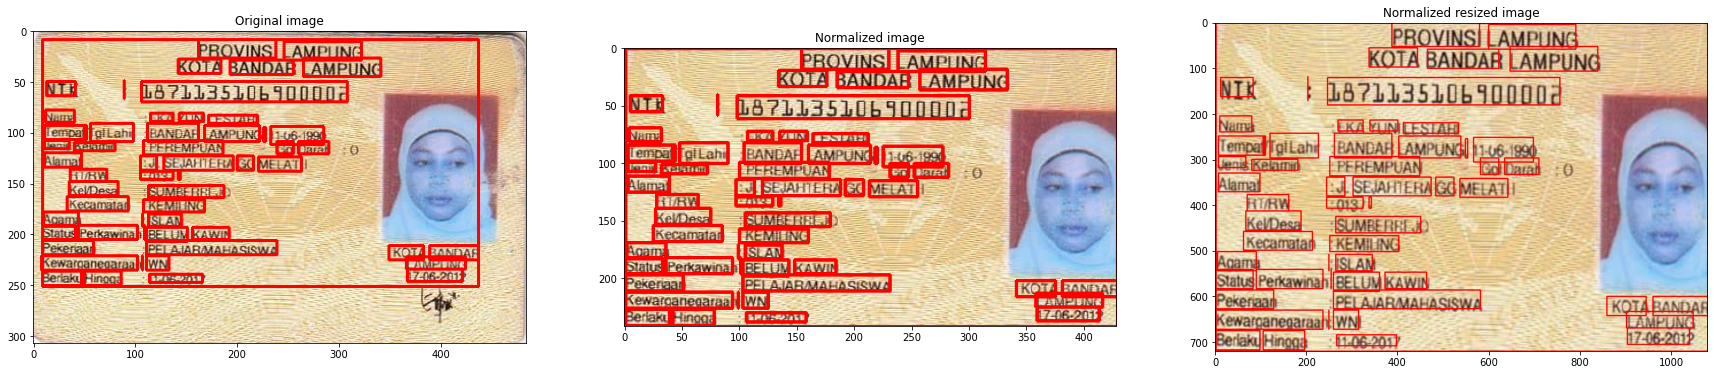

In [36]:
raw_train_real_df = get_raw_data_df(dirs=TRAIN_DATA, sub_folder_images="images_real", sub_folder_json='json_real', sub_folder_txt='txt_real')
print(f"Real train data length = {len(raw_train_real_df)}")
raw_train_real_df = raw_train_real_df.apply(get_normalized_entities, sub_folder_images="images_real", sub_folder_txt='txt_real', yolo_format=True, axis=1)
processed_train_real_df = prepare_df(raw_train_real_df, sub_folder_json='json_real', sub_folder_txt='txt_real', yolo_format=True)
plot_normalized_record(processed_train_real_df[processed_train_real_df['image']=='KTP10.png'], sub_folder_images="images_real")

In [37]:
processed_train_real_df[processed_train_real_df['image'] == 'KTP10.png'][['text', 'label_names']]

text        label_names
2050                  others
2051                  others
2052                  others
2053                  others
2054                  others
2055                  others
2056                  others
2057                  others
2058                     nik
2059                  others
2060                    nama
2061                    nama
2062                    nama
2063                  others
2064                  others
2065                  others
2066        tempat/tgl lahir
2067        tempat/tgl lahir
2068        tempat/tgl lahir
2069        tempat/tgl lahir
2070                  others
2071                  others
2072           jenis kelamin
2073                  others
2074                  others
2075                  others
2076                  alamat
2077                  alamat
2078                  alamat
2079                  alamat
2080                  alamat
2081                  others
2082                   rt/rw
2083                   rt/rw
2084                  others
2085                kel/desa
2086                  others
2087               kecamatan
2088                  others
2089                  others
2090                   agama
2091                  others
2092                  others
2093                  others
2094       status perkawinan
2095       status perkawinan
2096                  others
2097               pekerjaan
2098                  others
2099                  others
2100                  others
2101                  others
2102         kewarganegaraan
2103                  others
2104                  others
2105                  others
2106                  others
2107          berlaku hingga

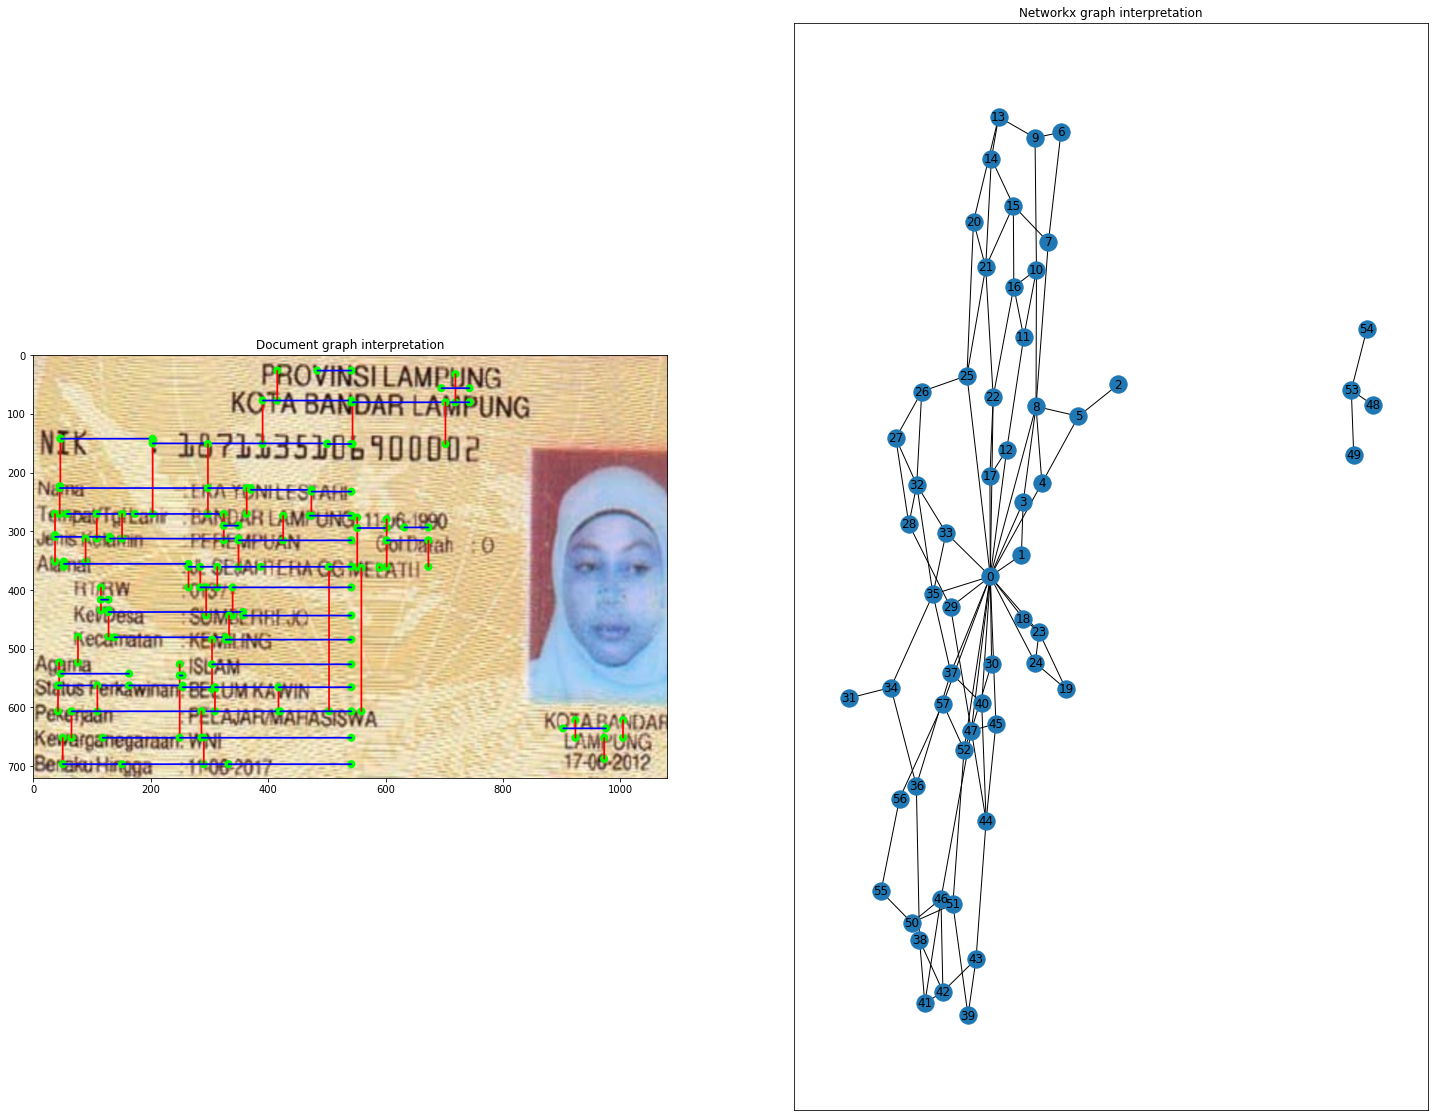

In [38]:
__df__, __graph_dict__, __graph__, __padded_adj_matrix__, __padded_features__, __adj_matrix__, __edge_index__, __features__, __data__ = Graph(processed_train_real_df[processed_train_real_df['image']=='KTP10.png']).graph()
plot_document_graph(__df__, __graph__, sub_folder_images='images_real')


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 34/36 [00:12<00:00,  2.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.68it/s]

Count of valid and cleaned data = 36


Data(x=[58, 51], edge_index=[2, 206], y=[58])

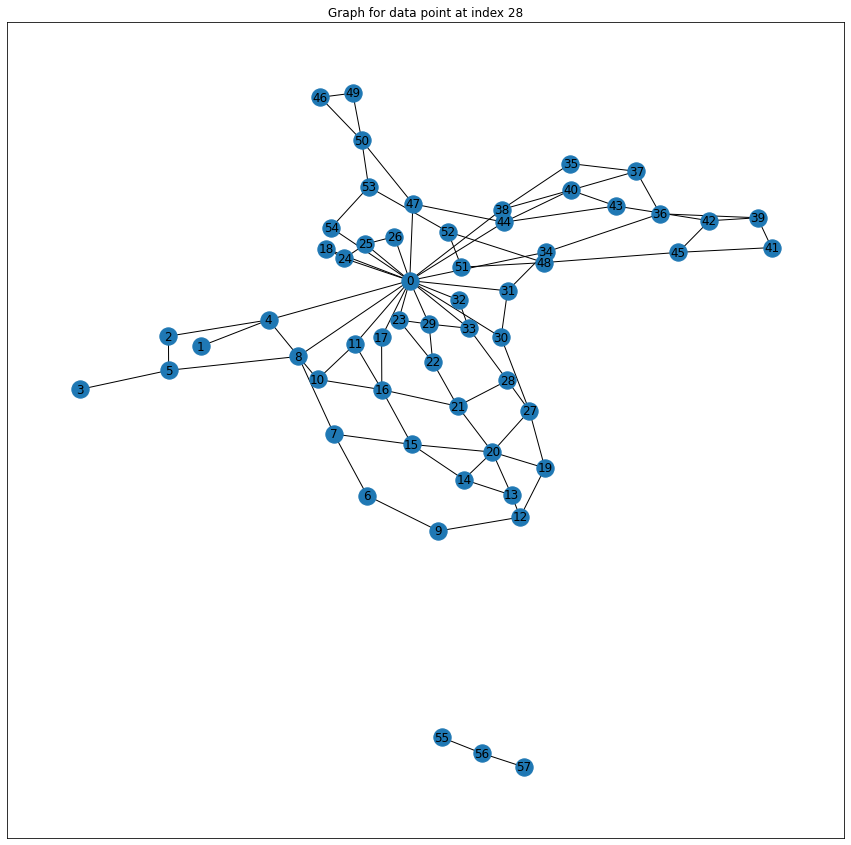

In [39]:
df_train_real_dataset = copy.deepcopy(processed_train_real_df[(~processed_train_real_df['label_names'].isnull())])
train_real_graphs, train_real_dataset = create_graph_dataset(df_train_real_dataset)
ind = random.choice(np.arange(0, len(train_real_graphs)))
plot_graph(train_real_graphs[ind], ind)
print('Count of valid and cleaned data =', len(train_real_dataset))
train_real_dataset[ind]

In [40]:
train_real_dataset, val_real_dataset, test_real_dataset_, data_real_module = get_data_module(train_real_dataset)

In [48]:
%%time
# mlflow.pytorch.autolog()
trainer_spectral = pl.Trainer(default_root_dir=f'../runs/saved_models/pytorch-lightning/synt/{DOC_TYPE}',
                             precision=32,
                             limit_train_batches=0.5,
                             gpus=1 if torch.cuda.is_available() else None, 
                             max_epochs=1500,
                             logger=TensorBoardLogger(f'../runs/saved_models/pytorch-lightning/synt/{DOC_TYPE}', name='spectral_gcn'),
                             callbacks=[
                                    LearningRateMonitor(logging_interval="step"), 
                                    ModelCheckpoint(monitor="train_loss"),
                                ],
                             resume_from_checkpoint='../runs/saved_models/pytorch-lightning/synt/ktp/spectral_gcn/version_0/checkpoints/epoch=49-step=2499.ckpt'
                             )
# with mlflow.start_run(run_name=SPECTRAL_EXPERIMENT_NAME + ' ' + datetime.now().strftime('%d-%m-%Y %H:%M'), tags={'time': datetime.now().strftime('%d-%m-%Y %H:%M')}) as run:
trainer_spectral.fit(LitGCN(ce_weights=ce_train_weights, is_spectral=True), data_real_module)
trainer_spectral.test(ckpt_path="best", datamodule=data_real_module)

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1905: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  rank_zero_deprecation(
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be r

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
Restoring states from the checkpoint path at ../runs/saved_models

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3840000033378601, 'test_loss': 2.694188356399536}
--------------------------------------------------------------------------------
CPU times: user 1min 50s, sys: 4.09 s, total: 1min 55s
Wall time: 1min 47s


[{'test_loss': 2.694188356399536, 'test_acc': 0.3840000033378601}]

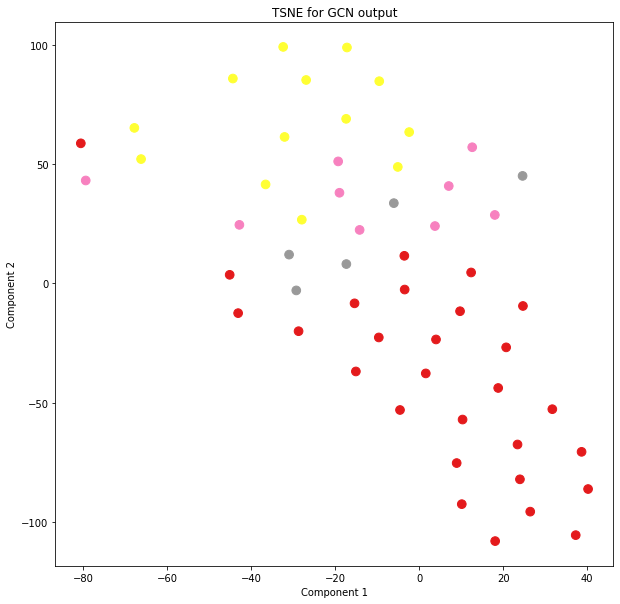

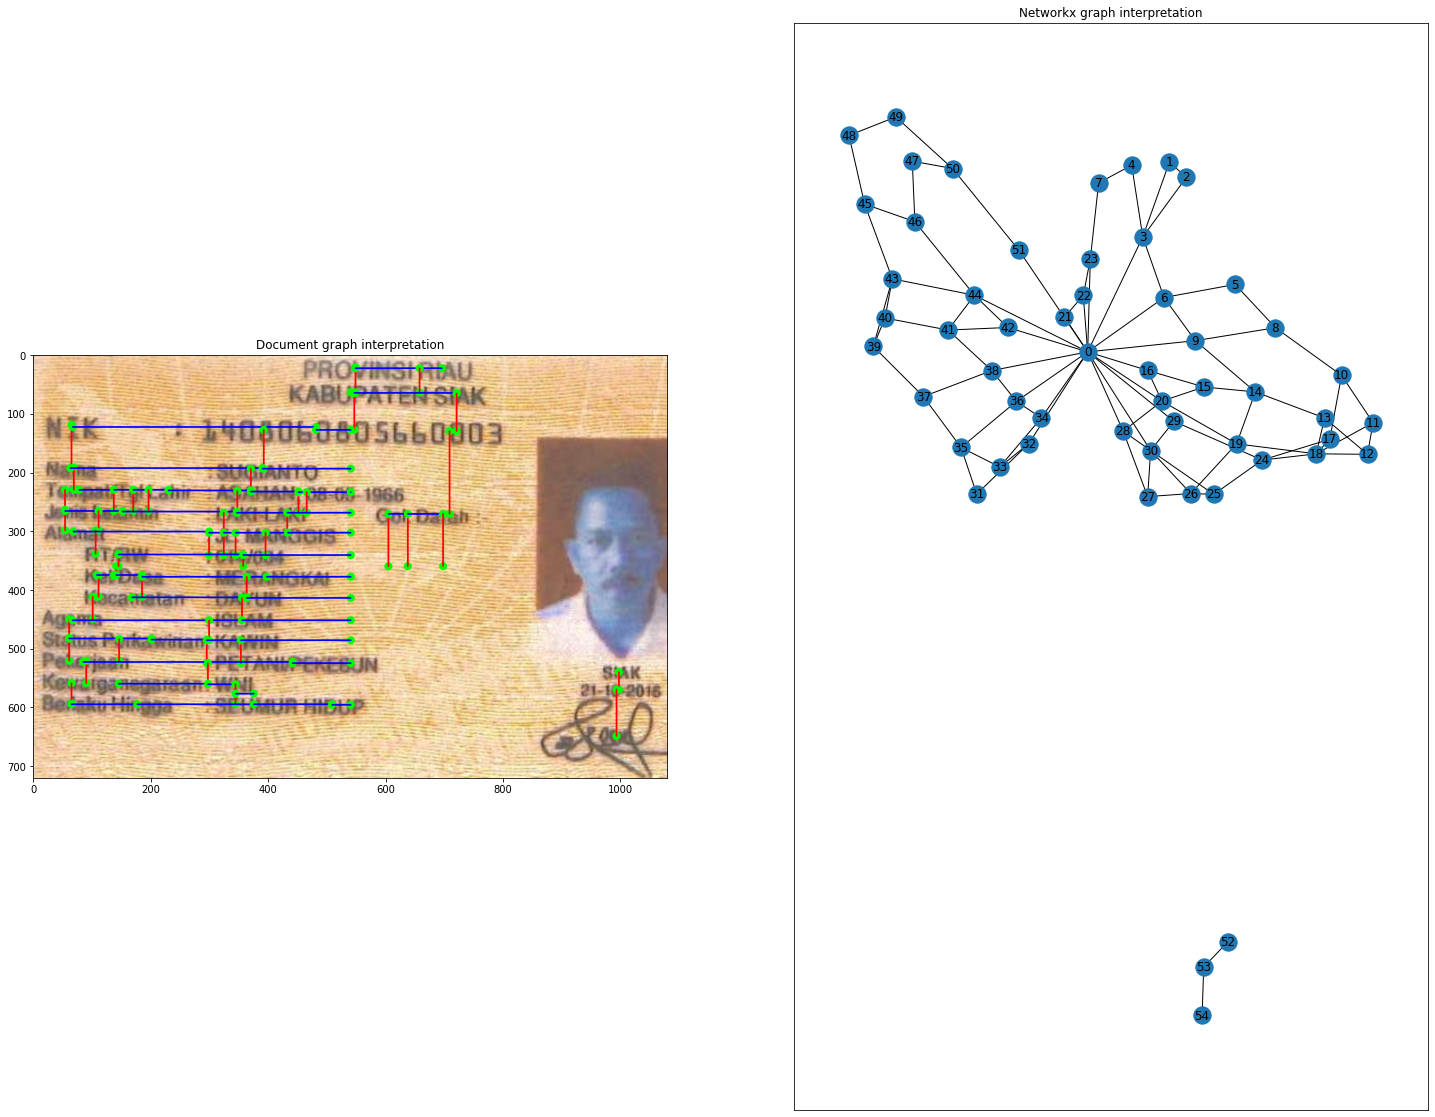

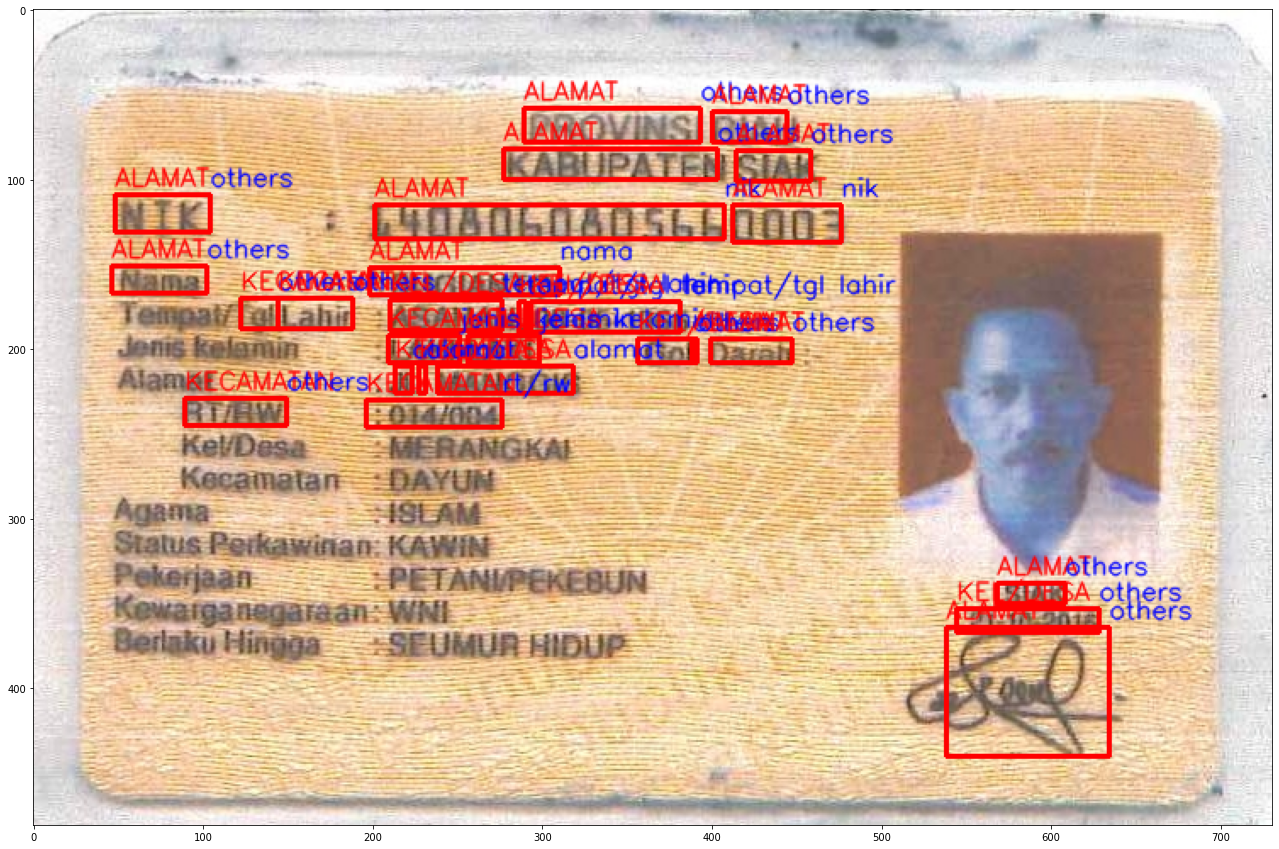

In [49]:
# __test_df__ = processed_train_real_df[processed_train_real_df['image'] == random.choice(processed_train_real_df['image'].unique().tolist())]
__test_df__ = processed_train_real_df[processed_train_real_df['image'] == 'Copy_STNK_&_KTP_0c.jpg']
__res__ = inference(__test_df__, LitGCN.load_from_checkpoint(checkpoint_path=trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_weights=ce_train_weights*0+1, is_spectral=True), sub_folder_images="images_real")

In [ ]:
processed_train_real_df[processed_train_real_df['image'] == 'KTP10.png'][['text', 'label_names']]